In [79]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import statistics as st
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from scipy.stats import shapiro 
from scipy.stats import lognorm
from scipy.stats import kstest
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 
from sklearn.metrics import cohen_kappa_score
import imblearn
from sklearn.metrics import balanced_accuracy_score
from imblearn.pipeline import make_pipeline
from statistics import mean, stdev
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn import linear_model
from sklearn import datasets

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import xgboost as xgb
from imblearn.over_sampling import SMOTE


In [48]:
red_wines = pd.read_csv("winequality-red.csv", sep = ";")
white_wines = pd.read_csv("winequality-white.csv", sep =";")

In [49]:
# formatting
red_wines.columns= red_wines.columns.str.replace(' ','_')
white_wines.columns = white_wines.columns.str.replace(' ','_')

#Quality categories
red_wines ['quality_label'] = red_wines['quality'].apply(lambda value: 'low' if value <= 5 
                                                        else 'medium' if value <= 7 
                                                        else 'high')

red_wines['quality_label'] = pd.Categorical(red_wines['quality_label'],
categories=['low', 'medium', 'high'])

white_wines ['quality_label'] = white_wines['quality'].apply(lambda value: 'low' if value <= 5 
                                                        else 'medium' if value <= 7 
                                                        else 'high')

white_wines["quality_label"] = pd.Categorical(white_wines["quality_label"], categories = ["low","medium","high"])

# Type of wine categories
red_wines ["type"] = 'Red Wine'
red_wines['type'] = pd.Categorical(red_wines['type'],
categories=["Red Wine","White Wine"])

white_wines ["type"] = 'White Wine'
white_wines['type'] = pd.Categorical(white_wines['type'],
categories=["Red Wine","White Wine"])

# merge datasets
white_and_red = pd.merge(red_wines, white_wines, how = "outer")

#make copy
white_and_red_ml= white_and_red.copy()

In [50]:
white_and_red["quality_label"].head(10)

0    medium
1      high
2    medium
3       low
4      high
5    medium
6    medium
7       low
8       low
9       low
Name: quality_label, dtype: category
Categories (3, object): ['low', 'medium', 'high']

In [51]:
white_and_red["quality_label"].tail(10)

6487    medium
6488    medium
6489    medium
6490    medium
6491    medium
6492       low
6493       low
6494       low
6495    medium
6496       low
Name: quality_label, dtype: category
Categories (3, object): ['low', 'medium', 'high']

In [52]:
string_col = white_and_red.select_dtypes(include="object").columns

In [53]:
X = white_and_red.drop(['quality'], axis=1)
y = white_and_red['type']


print("original:", white_and_red.shape, "\nX:", X.shape, "\ny:", y.shape)

original: (6497, 14) 
X: (6497, 13) 
y: (6497,)


# Filtering outliers

In [54]:
from scipy.stats import zscore
white_and_red_clean= white_and_red.drop("quality", axis=1)
numeric_columns = white_and_red_clean.select_dtypes(include=['float64', 'int64']).columns.tolist()
z_score_dict = {}
for x in numeric_columns:
    z_score_dict[f'z_score_{x}'] = zscore(white_and_red[x])


# Create a DataFrame from the z_score_dict
z_score_df = pd.DataFrame(z_score_dict, index=white_and_red.index)

# Concatenate the original DataFrame with the z_score DataFrame

white_and_red_with_zscores = pd.concat([white_and_red_clean, z_score_df], axis=1)

# # Filter rows where the absolute value of all z_scores is less than 3
z_score_columns = z_score_df.columns
filtered_white_and_red = white_and_red_with_zscores[(white_and_red_with_zscores[z_score_columns].abs() < 3).all(axis=1)]
filtered_white_and_red

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,...,z_score_volatile_acidity,z_score_citric_acid,z_score_residual_sugar,z_score_chlorides,z_score_free_sulfur_dioxide,z_score_total_sulfur_dioxide,z_score_density,z_score_pH,z_score_sulphates,z_score_alcohol
1,3.9,0.225,0.40,4.20,0.030,29.0,118.0,0.98900,3.57,0.36,...,-0.696534,0.559966,-0.261325,-0.743168,-0.085943,0.039907,-1.899864,2.186282,-1.151040,1.935402
3,4.2,0.215,0.23,5.10,0.041,64.0,157.0,0.99688,3.42,0.44,...,-0.757278,-0.609973,-0.072147,-0.429160,1.886106,0.729958,0.728167,1.253300,-0.613385,-2.089350
4,4.4,0.320,0.39,4.30,0.030,31.0,127.0,0.98904,3.46,0.36,...,-0.119460,0.491146,-0.240305,-0.743168,0.026746,0.199149,-1.886524,1.502096,-1.151040,1.935402
5,4.4,0.460,0.10,2.80,0.024,31.0,111.0,0.98816,3.48,0.34,...,0.730964,-1.504633,-0.555601,-0.914446,0.026746,-0.083949,-2.180010,1.626493,-1.285453,2.186949
6,4.4,0.540,0.09,5.10,0.038,52.0,97.0,0.99022,3.41,0.40,...,1.216920,-1.573453,-0.072147,-0.514799,1.209975,-0.331660,-1.492987,1.191102,-0.882212,1.432308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6364,11.1,0.350,0.48,3.10,0.090,5.0,21.0,0.99860,3.17,0.53,...,0.062773,1.110526,-0.492541,0.969605,-1.438205,-1.676376,1.301798,-0.301669,-0.008524,0.006875
6365,11.1,0.390,0.54,2.70,0.095,21.0,101.0,1.00010,3.13,0.51,...,0.305752,1.523445,-0.576620,1.112336,-0.536697,-0.260885,1.802058,-0.550465,-0.142937,-0.831615
6366,11.1,0.420,0.47,2.65,0.085,9.0,34.0,0.99736,3.24,0.77,...,0.487985,1.041706,-0.587130,0.826874,-1.212828,-1.446359,0.888250,0.133722,1.604440,1.348459
6367,11.1,0.440,0.42,2.20,0.064,14.0,19.0,0.99758,3.25,0.57,...,0.609474,0.697606,-0.681719,0.227403,-0.931107,-1.711763,0.961621,0.195921,0.260304,-0.076974


In [55]:
numeric_white_and_red = white_and_red.select_dtypes(include="float64")

In [56]:
white_and_red_numeric = white_and_red_clean.select_dtypes(include=['float64', 'int64'])
filtered_wr_df = white_and_red.copy()
for column in white_and_red_numeric.columns:
        q1 = np.quantile(white_and_red_numeric[column], 0.25)
        q3 = np.quantile(white_and_red_numeric[column], 0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        # Filter rows based on the column's outlier range
        filtered_wr_df = filtered_wr_df[(filtered_wr_df[column] >= lower) & (filtered_wr_df[column] <= upper)]
print("white and red shape; ", white_and_red.shape, "\nfiltered white and red shape: ", filtered_wr_df.shape)

white and red shape;  (6497, 14) 
filtered white and red shape:  (5024, 14)


In [57]:
numeric_white_and_red_out = numeric_white_and_red[~((numeric_white_and_red < (Q1 - 1.5 * IQR)) |(numeric_white_and_red > (Q3 + 1.5 * IQR))).any(axis=1)]
print(numeric_white_and_red_out.shape)

(5024, 11)


# Encoding

In [58]:
enc = OrdinalEncoder(categories=[['low', 'medium', 'high']])
white_and_red['quality_label_encode'] = enc.fit_transform(white_and_red_ml[['quality_label']])
white_and_red["quality_label"].head()


0    medium
1      high
2    medium
3       low
4      high
Name: quality_label, dtype: category
Categories (3, object): ['low', 'medium', 'high']

In [59]:
white_and_red.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,quality_label,type,quality_label_encode
0,3.8,0.310,0.02,11.1,0.036,20.0,114.0,0.99248,3.75,0.44,12.4,6,medium,White Wine,1.0
1,3.9,0.225,0.40,4.2,0.030,29.0,118.0,0.98900,3.57,0.36,12.8,8,high,White Wine,2.0
2,4.2,0.170,0.36,1.8,0.029,93.0,161.0,0.98999,3.65,0.89,12.0,7,medium,White Wine,1.0
3,4.2,0.215,0.23,5.1,0.041,64.0,157.0,0.99688,3.42,0.44,8.0,3,low,White Wine,0.0
4,4.4,0.320,0.39,4.3,0.030,31.0,127.0,0.98904,3.46,0.36,12.8,8,high,White Wine,2.0


In [60]:
# split data

X=white_and_red.drop(["type","quality_label","quality", "quality_label_encode"], axis=1)
y= white_and_red["quality_label_encode"]

print("original:", white_and_red.shape, "\nX:", X.shape, "\ny:", y.shape)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
y_test.shape

original: (6497, 15) 
X: (6497, 11) 
y: (6497,)


(1300,)

In [61]:
# Standarization and normalization

norm = MinMaxScaler().fit(X_train)

# transform training data
X_train_norm = norm.transform(X_train)

# transform testing data
X_test_norm = norm.transform(X_test)

In [62]:
## logistic regression
LR_model = LogisticRegression(max_iter=700)
LR_model.fit(X_train_norm, y_train)
preds = LR_model.predict(X_test_norm)

## Accuracy
acc = accuracy_score(y_test, preds)
print(acc)
LR_model

0.7038461538461539


LogisticRegression(max_iter=700)

In [65]:
# le = LabelEncoder()
# white_and_red_filtered ['quality_label'] = le.fit_transform(white_and_red_filtered['quality_label'])
enc = OrdinalEncoder(categories=[['low', 'medium', 'high']])
filtered_wr_df['quality_label_encoded'] = enc.fit_transform(filtered_wr_df[['quality_label']])


from sklearn.model_selection import train_test_split
X2=filtered_wr_df.drop(["type","quality_label","quality","quality_label_encoded"], axis=1)
y2= filtered_wr_df["quality_label_encoded"]

print("original:", filtered_wr_df .shape, "\nX:", X2.shape, "\ny:", y2.shape)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.20, random_state=42)
## standarization
norm = MinMaxScaler().fit(X2_train)

# transform training data
X2_train_norm = norm.transform(X2_train)

# transform testing data
X2_test_norm = norm.transform(X2_test)
## logistic regression
LR_model2 = LogisticRegression(max_iter=700)
LR_model2.fit(X2_train_norm, y2_train)
preds2 = LR_model2.predict(X2_test_norm)

## Accuracy
acc2 = accuracy_score(y2_test, preds2)

print(f"logistic regression accuracy: {acc2:.4f}")
kappa_lr = cohen_kappa_score(preds2, y2_test)
print(f"Cohen-Kappa score: {kappa_lr:.4f}")
print(f"The balanced accuracy score is {balanced_accuracy_score(y2_test, preds2):.4f}")

original: (5024, 15) 
X: (5024, 11) 
y: (5024,)
logistic regression accuracy: 0.7224
Cohen-Kappa score: 0.3628
The balanced accuracy score is 0.4587


# Random Forest

## Model 1

In [70]:
RF_clf = RandomForestClassifier(random_state=42)
# fit model
RF_clf.fit(X2_train_norm, y2_train)
# make predictions
RF_preds = RF_clf.predict(X2_test_norm)

RF_acc = accuracy_score(y2_test, RF_preds)
print( f"Random Forest Accuracy score: {RF_acc:.4f}")
kappa = cohen_kappa_score(RF_preds, y2_test)
print(f"Cohen-Kappa score: {kappa:.4f}")
print(f"The balanced accuracy score is {balanced_accuracy_score(y2_test, RF_preds):.4f}")

Random Forest Accuracy score: 0.7990
Cohen-Kappa score: 0.5583
The balanced accuracy score is 0.6192


# Balancing the data set

## Model 2

In [71]:
RF2_clf = RandomForestClassifier(random_state=42, class_weight="balanced")
# fit model
RF2_clf.fit(X2_train_norm, y2_train)
# make predictions
RF2_preds = RF2_clf.predict(X2_test_norm)

RF2_acc = accuracy_score(y2_test, RF2_preds)
print( f"Random Forest Accuracy score: {RF2_acc:.4f}")
kappa = cohen_kappa_score(RF2_preds, y2_test)
print(f"Cohen-Kappa score: {kappa:.4f}")
print(f"The balanced accuracy score is {balanced_accuracy_score(y2_test, RF2_preds):.4f}")

Random Forest Accuracy score: 0.8090
Cohen-Kappa score: 0.5757
The balanced accuracy score is 0.6153


In [72]:
labels = np.unique(y2_test)
a = confusion_matrix(y2_test, RF2_preds, labels=labels)
a = pd.DataFrame(a)
display(a)

,0,1,2
0,214,109,0
1,56,589,0
2,0,27,10


## Model 3

# Smoke

In [81]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X2, y2)

# Check new class distribution
print(pd.Series(y_resampled).value_counts())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

## standarization
norm = MinMaxScaler().fit(X_train)

# transform training data
X_train_norm = norm.transform(X_train)

# transform testing data
X_test_norm = norm.transform(X_test)
# define model
RF = RandomForestClassifier(random_state=42, class_weight="balanced")
# fit model
RF.fit(X_train_norm, y_train)
# make predictions
RF_pred = RF_clf.predict(X_test_norm)

RF_acc = accuracy_score(y_test, RF_pred)
print( f"Random Forest Accuracy score: {RF_acc:.4f}")
kappa = cohen_kappa_score(RF_pred, y_test)
print(f"Cohen-Kappa score: {kappa:.4f}")
print(f"The balanced accuracy score is {balanced_accuracy_score(y_test, RF_pred):.4f}")

quality_label_encoded
0.0    3187
1.0    3187
2.0    3187
Name: count, dtype: int64
Random Forest Accuracy score: 0.7224
Cohen-Kappa score: 0.5836
The balanced accuracy score is 0.7225


# Xgboost 

In [83]:
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # For multiclass classification
    num_class=3,               # Number of classes (low, medium, high)
    eval_metric='mlogloss',    # Metric for multiclass
    random_state=42
)

# Train the model
xgb_model.fit(X_train_norm, y_train)

# predictions
xgb_pred = xgb_model.predict(X_test_norm)

# Classification report
print("Classification Report:")
print(classification_report(y_test, xgb_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, xgb_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87       637
         1.0       0.86      0.84      0.85       638
         2.0       0.96      0.98      0.97       638

    accuracy                           0.90      1913
   macro avg       0.90      0.90      0.90      1913
weighted avg       0.90      0.90      0.90      1913

Confusion Matrix:
[[557  76   4]
 [ 84 533  21]
 [  2  11 625]]


In [85]:
# RF With SMOTE in pipe line, no 
pipe = make_pipeline(imblearn.over_sampling.SMOTE(), 
                     RandomForestClassifier( class_weight="balanced", random_state=42))
pipe.fit(X2_train_norm, y2_train)
y2_pred = pipe.predict(X2_test_norm)
print(f"The accuracy score is {accuracy_score(y2_test, y2_pred):.4f}")
print(f"The balanced accuracy score is {balanced_accuracy_score(y2_test, y2_pred):.4f}")

The accuracy score is 0.7900
The balanced accuracy score is 0.6879


In [86]:
# LR with SMOTE
pipe2 = make_pipeline(imblearn.over_sampling.SMOTE(), 
                     LogisticRegression( class_weight="balanced", random_state=42))
pipe2.fit(X2_train_norm, y2_train)
y3_pred = pipe2.predict(X2_test_norm)
print(f"The accuracy score is {accuracy_score(y2_test, y3_pred):.4f}")
print(f"The balanced accuracy score is {balanced_accuracy_score(y2_test, y3_pred):.4f}")

The accuracy score is 0.4975
The balanced accuracy score is 0.5961


Model 3
Random forest with Stratified K-fold cross validation

In [110]:
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(X2)
# Create  classifier object.
# lr = linear_model.LogisticRegression()
rf = RandomForestClassifier(class_weight="balanced")

# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
lst_accu_stratified = []
lst_kappa =[]
lst_balanced_accuracy_score =[]
  
for train_index, test_index in skf.split(X2,y2):
    x_train_fold, x_test_fold = x_scaled[train_index], x_scaled[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    rf.fit(x_train_fold, y_train_fold)
    rf_pred = rf.predict(x_test_fold) 
    kappa = cohen_kappa_score(rf_pred, y_test_fold)
    lst_accu_stratified.append(rf.score(x_test_fold, y_test_fold))
    balanced_acc_sc = balanced_accuracy_score(y_test_fold, rf_pred)
    lst_balanced_accuracy_score.append(f"{balanced_acc_sc:.4f}")
    lst_kappa.append(f"{kappa:.4f}")


  
 #Print the output.
print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified))
print("\nList of possible Cohen-Kappa score:", lst_kappa)
print("\nList of possible balanced accuracy score:", lst_balanced_accuracy_score)

List of possible accuracy: [0.5864811133200796, 0.6123260437375746, 0.6302186878727635, 0.5984095427435387, 0.5856573705179283, 0.6135458167330677, 0.6175298804780877, 0.5816733067729084, 0.6254980079681275, 0.6195219123505976]

Maximum Accuracy That can be obtained from this model is: 63.02186878727635 %

Minimum Accuracy: 58.16733067729084 %

Overall Accuracy: 60.70861682494674 %

Standard Deviation is: 0.01767569120299462

List of possible Cohen-Kappa score: ['0.0820', '0.1167', '0.1576', '0.1150', '0.0873', '0.1484', '0.1162', '0.0741', '0.1629', '0.1544']

List of possible balanced accuracy score: ['0.3577', '0.3797', '0.4094', '0.4120', '0.3846', '0.4278', '0.4012', '0.3730', '0.4398', '0.4399']


## Confusion Matrix RF (k-fold)

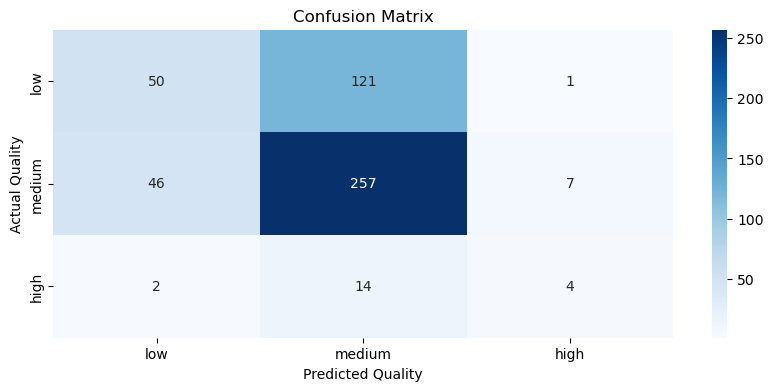

In [111]:
cm = confusion_matrix(y_test_fold, rf_pred)
plt.figure(figsize=(10, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=["low","medium","high"], yticklabels=["low","medium","high"])
plt.xlabel('Predicted Quality')
plt.ylabel('Actual Quality')
plt.title('Confusion Matrix')
plt.show()

# Confusion matrix XGBoost ( without kfold)

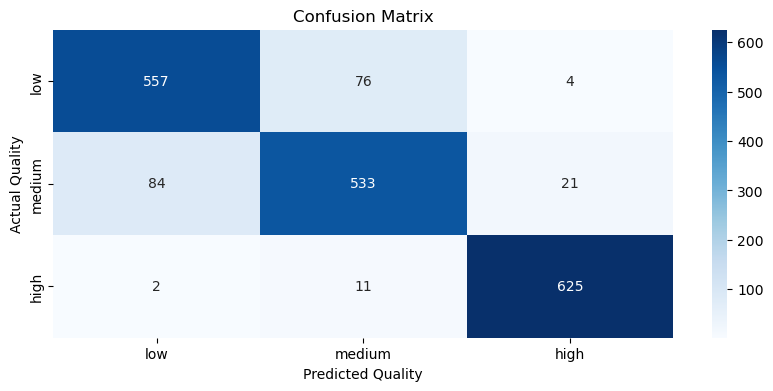

In [89]:
#!SECTION check for the variables! they are repeated
cm = confusion_matrix(y_test, xgb_pred)
plt.figure(figsize=(10, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=["low","medium","high"], yticklabels=["low","medium","high"])
plt.xlabel('Predicted Quality')
plt.ylabel('Actual Quality')
plt.title('Confusion Matrix')
plt.show()

## XGBOOST with stratifed kfold cross validation

In [114]:
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # For multiclass classification
    num_class=3,               # Number of classes (low, medium, high)
    eval_metric='mlogloss',    # Metric for multiclass
    random_state=42
)

scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(X2)

# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
lst_accu_stratified = []
lst_kappa =[]
lst_balanced_accuracy_score =[]
  
for train_index, test_index in skf.split(X2,y2):
    x_train_fold, x_test_fold = x_scaled[train_index], x_scaled[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    xgb_model.fit(x_train_fold, y_train_fold)
    xgb_pred = xgb_model.predict(x_test_fold) 
    kappa = cohen_kappa_score(xgb_pred, y_test_fold)
    lst_accu_stratified.append(xgb_model.score(x_test_fold, y_test_fold))
    balanced_acc_sc = balanced_accuracy_score(y_test_fold, xgb_pred)
    lst_balanced_accuracy_score.append(f"{balanced_acc_sc:.4f}")
    lst_kappa.append(f"{kappa:.4f}")


  
# Print the output.
print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified))
print("\nList of possible Cohen-Kappa score:", lst_kappa)
print("\nList of possible balanced accuracy score:", lst_balanced_accuracy_score)

List of possible accuracy: [0.5924453280318092, 0.6202783300198808, 0.5805168986083499, 0.610337972166998, 0.5856573705179283, 0.5976095617529881, 0.5936254980079682, 0.5378486055776892, 0.6175298804780877, 0.603585657370518]

Maximum Accuracy That can be obtained from this model is: 62.02783300198808 %

Minimum Accuracy: 53.78486055776892 %

Overall Accuracy: 59.394351025322166 %

Standard Deviation is: 0.023624250565158267

List of possible Cohen-Kappa score: ['0.1214', '0.1710', '0.0711', '0.1533', '0.1055', '0.1217', '0.0901', '0.0148', '0.1635', '0.1467']

List of possible balanced accuracy score: ['0.3708', '0.4005', '0.3543', '0.4288', '0.3920', '0.4094', '0.3934', '0.3358', '0.4133', '0.4399']


## confusion matrix xgboost with fold

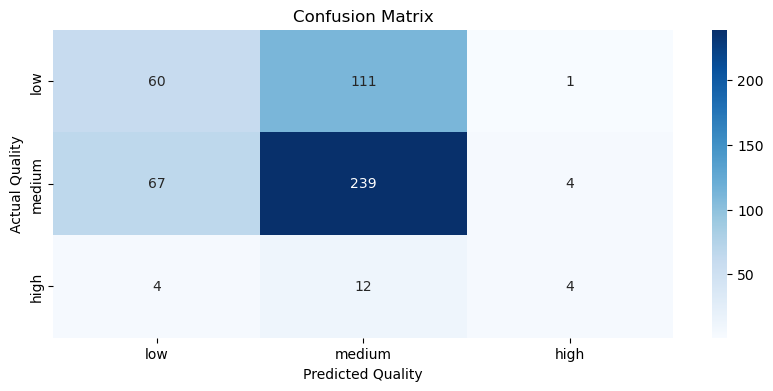

In [115]:
cm = confusion_matrix(y_test_fold, xgb_pred)
plt.figure(figsize=(10, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=["low","medium","high"], yticklabels=["low","medium","high"])
plt.xlabel('Predicted Quality')
plt.ylabel('Actual Quality')
plt.title('Confusion Matrix')
plt.show()

In [117]:
y_test_fold.value_counts()

quality_label_encode
1.0    310
0.0    172
2.0     20
Name: count, dtype: int64

In [118]:
filtered_wr_df["quality_label"].value_counts()

quality_label
medium    3187
low       1664
high       173
Name: count, dtype: int64

In [119]:
import numpy as np

param_grid = {
    'n_estimators': [250, 300, 350],
    'max_depth': [15, 20, None],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True],
    'class_weight': ['balanced']
}

# Gride

In [120]:
#importing random forest classifier
from sklearn.ensemble import RandomForestClassifier as randomforestclassifier
from sklearn.model_selection import RandomizedSearchCV

#initializing the model
RF_model = randomforestclassifier(random_state=42)

#initializing the RandomizedSearchCV
RS_grid = RandomizedSearchCV(
    estimator=RF_model,
    param_distributions=param_grid,
    n_iter=30,
    cv=5,
    scoring='balanced_accuracy',
    n_jobs=-1,
    return_train_score=True
)

#fitting the model
RS_grid.fit(X_train, y_train)

preds = RS_grid.predict(X_test) #predicting
X_test
y_test

# accuracy score
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, preds) #accuracy
print(acc) #accuracy

0.8980658651332984


## confusion matrix Gride

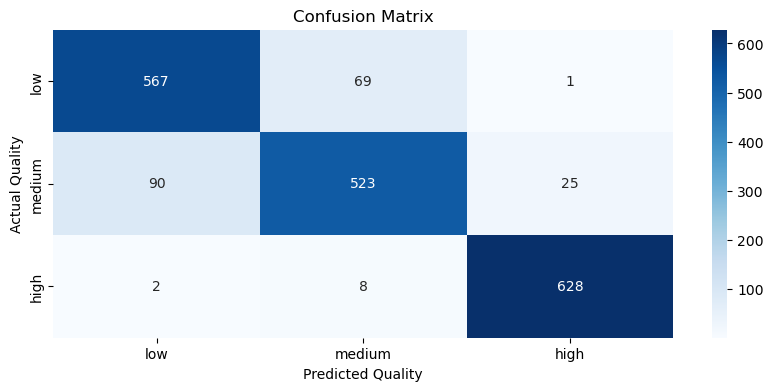

In [121]:
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(10, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=["low","medium","high"], yticklabels=["low","medium","high"])
plt.xlabel('Predicted Quality')
plt.ylabel('Actual Quality')
plt.title('Confusion Matrix')
plt.show()